# Importing Libraries

In [1]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import splitfolders
import PIL
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import glob
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization

# Importing Dataset

In [2]:
import splitfolders
class config:
    
    data_path = 'Dataset/'
    
    path_train = "./output/train"
    path_test = "./output/test"

In [3]:
splitfolders.ratio(config.data_path, output="output", seed=101, ratio=(.8, .2))

Copying files: 3000 files [00:02, 1156.20 files/s]


In [4]:
IMAGE_SIZE = [224,224]

In [5]:
TRAIN_PATH = "output/train"
VAL_PATH = "output/val"

PATHS = [TRAIN_PATH, VAL_PATH]



In [6]:
BATCH_SIZE = 64
EPOCHS = 5
IMAGE_SHAPE = (224, 224)

In [7]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_gen = datagen.flow_from_directory(directory = TRAIN_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

val_gen = datagen.flow_from_directory(directory = VAL_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


# Resnet 50

In [8]:
from tensorflow.keras.models import Model
import tensorflow as tf

resnet_base_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='max')

In [9]:
resnet_base_model.trainable = False

In [10]:
inputs = resnet_base_model.input

x = BatchNormalization()(resnet_base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.45, seed=1234)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.45, seed=1235)(x)
x = Flatten()(x)

outputs = Dense(2, activation='softmax')(x)

resnet_model = Model(inputs=inputs, outputs=outputs)

In [11]:
resnet_model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
CHECKPOINT_PATH_MODEL_FIRST = "first_version"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH_MODEL_FIRST,
                                      monitor='val_loss',
                                      save_best_only=True)

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 2, restore_best_weights=True)

In [14]:
history = resnet_model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[checkpoint_callback, early_stopping])

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 0.6365 - accuracy: 0.7029WARNING:tensorflow:From C:\Users\TruProjects\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: first_version\assets
38/38 [==============================] - 127s 3s/step - loss: 0.6365 - accuracy: 0.7029 - val_loss: 0.7948 - val_accuracy: 0.5683
Epoch 2/20
38/38 [==============================] - 131s 3s/step - loss: 0.5011 - accuracy: 0.7725 - val_loss: 0.6488 - val_accuracy: 0.6550
Epoch 3/20
38/38 [==============================] - 128s 3s/step - loss: 0.4300 

In [15]:
resnet_model.save('resnet50.h5')

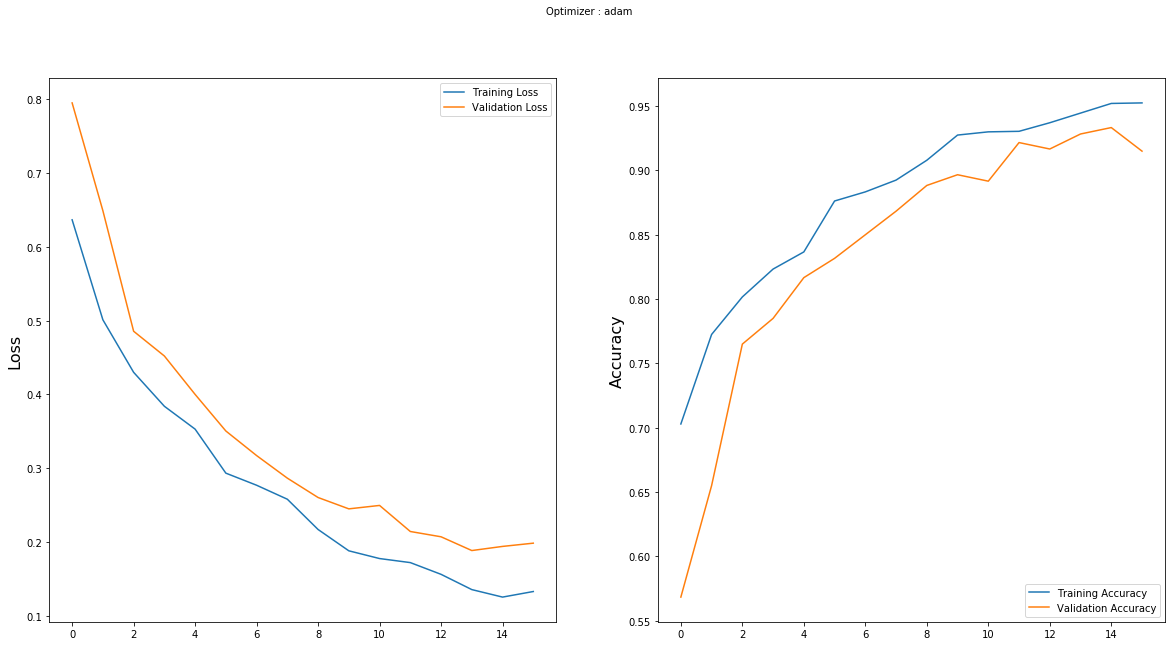

In [16]:
import matplotlib.pyplot as plt

x=history
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()